In [1]:
import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.python.keras.backend as K
import tensorflow.python.keras.layers as layers
from tensorflow.python.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    inp = tf.keras.layers.Input(shape=(num_columns,))
    x0 = tf.keras.layers.BatchNormalization()(inp)

    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)

    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name='decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, name='ae_action')(x_ae)

    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)

    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)

    out = tf.keras.layers.Dense(num_labels, name='action')(x)

    model = tf.keras.models.Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss={'decoder': tf.keras.losses.MeanSquaredError(),
                        'ae_action': tf.keras.losses.Huber(delta = 1.3),
                        'action': tf.keras.losses.Huber(delta = 1.3),
                        },
                  metrics={'decoder': tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                           'ae_action': tfa.metrics.r_square.RSquare(name = 'rsquare'),
                           'action': tfa.metrics.r_square.RSquare(name = 'rsquare'),
                           },
                  )

    return model

2023-11-29 16:42:37.185411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow_addons as tfa
def create_model(n_in, n_out, layers, dropout_rate, optimizer, metrics):

    inp = tf.keras.layers.Input(shape = (n_in, ))

    x=inp
    for i,hidden_units in enumerate(layers):
        x = tf.keras.layers.BatchNormalization()(x)
        if i>0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        else:
            x = tf.keras.layers.Dropout(.01)(x)
        x = tf.keras.layers.Dense(hidden_units)(x)
        x = tf.keras.layers.Activation('relu')(x)

    out = tf.keras.layers.Dense(n_out, name = 'action')(x)

    model = tf.keras.models.Model(inputs = inp, outputs = out)
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.Huber(delta = 1.3),
                  metrics = metrics,
#                   run_eagerly=True
                 )

    return model

/Users/johnz/anaconda3/envs/python310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/johnz/anaconda3/envs/python310/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, d

In [3]:
class Params: pass
param=Params()

In [4]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from itertools import islice
import tscv

def generate_label(df, threshold = 0.002):
    df['label'] = 0
    df.loc[(df['target_15m'] <= -1*threshold), 'label'] = 1
    df.loc[(df['target_15m'] >= threshold), 'label'] = 2
    return df

def get_na_features(df, train_features):
    tmp = pd.DataFrame(df[train_features].isnull().sum())
    tmp = tmp[tmp[0] > 0].reset_index()
    tmp.columns = ['feat', 'cnt']
    tmp = tmp.sort_values('cnt')
    feat_groups = dict(tmp.groupby('cnt')['feat'].agg(lambda x: list(x)))
    return feat_groups

In [5]:
def generate_labels(df, target_interval = 60, interval = 1):
  n_periods = int(target_interval / interval)
  columns = [f'target_{target_interval}m', f'close_{target_interval}m', 'close_t']
  print(f'Label is {columns}')
  df[f'target_{target_interval}m'] = df['close'].pct_change(-n_periods)
  df[f'close_{target_interval}m'] = df['close'].shift(-n_periods)
  df['close_t'] = df['close']
  df['close_5m'] = df['close'].shift(-1)
  df = df.dropna(subset = [f'target_{target_interval}m'], axis = 0)
  return df, columns


In [6]:
features_to_remove = ['quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
                      'taker_buy_quote_asset_volume', 'sum_open_interest', 'sum_open_interest_value',
                      'count_toptrader_long_short_ratio', 'sum_toptrader_long_short_ratio', 'count_long_short_ratio',
                      'sum_taker_long_short_vol_ratio']

In [8]:
from joblib import load, dump
date = f'11_23'
directory = f'spot_data_11_23'

In [8]:
train = False
df = pd.read_feather('../data/df_btc_with_features_5m_spot.feather')

cols_to_drop = ['open_time', 'close_time', 'ignore', 'token', 'close_t', 'close_5m',
                'create_time', 'symbol', 'returns', 'returns_5m',
                'target_15m', 'label', 'token_code', 'target_5m'] + features_to_remove

df = df.loc[df['token'] == 'BTCUSDT'].reset_index(drop = True)

df = df.sort_values(by='open_time', ignore_index=True)
# df = generate_label(df, threshold=0.002)
# df = generate_five_minute_labels(df)

interval = 5
# df, columns = generate_labels(df, target_interval = target_interval, interval = interval)
# cols_to_drop += columns
df['close_5m'] = df['close'].shift(-1)
df['close_t'] = df['close'].copy()

start_time = df['open_time'].min()
end_time = df['open_time'].max()
dates = df['open_time'].unique()
n = len(dates)
train_idx = int(0.7 * n)
valid_idx = int(0.9 * n)
train_end = dates[train_idx]
valid_end = dates[valid_idx]

train_df = df.loc[df['open_time'] < train_end].reset_index(drop=True)
valid_df = df.loc[(train_end <= df['open_time']) & (df['open_time'] < valid_end)].reset_index(drop=True)

train_df = pd.concat([train_df, valid_df], axis = 0)

test_df = df.loc[(df['open_time'] >= valid_end)].reset_index(drop=True)

valid_df = test_df.copy()

train_features = [x for x in df.columns if (x not in cols_to_drop)]
object_cols = train_df[train_features].select_dtypes(include=object).columns
train_df[object_cols] = train_df[object_cols].astype(float)

nan_features = get_na_features(train_df, train_features)
feature_cols = pd.DataFrame(train_features)
dtype_df = pd.DataFrame(train_df[train_features].select_dtypes(exclude=[float]).columns)
train_features = [x for x in train_features if x not in dtype_df.values]
### model parameters
# param.layers = [500, 350, 200]
# param.dropout_rate = 0.35
#
#
# ###training parameters
# param.bs = 8192
# param.lr = 0.002
# param.epochs = 30
# param.wd = 0.02

def normalize_columns_infer(df, means, stds):
    features = means.index.tolist()
    for feature in features:
        mean = means.loc[feature]
        std = stds.loc[feature]
        df[feature] = (df[feature] - mean) / std
    return df

from joblib import load, dump
date = f'11_23'
directory = f'spot_data_11_23_delta'
means = load(f'../output/{directory}/means_return_huber.joblib')
std = load(f'../output/{directory}/std_return_huber.joblib')
train_features_test = load(f'../output/{directory}/train_features_test_return_huber.joblib')

valid_df = normalize_columns_infer(valid_df, means, std)

x_val = valid_df[train_features_test]

params = {'num_columns': len(train_features_test),
        'num_labels': 1,
        'hidden_units': [96, 96, 896, 448, 448, 256],
        'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882,
                          0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448],
        'ls': 0,
        'lr': 1e-3,
        }

print(f'Shape of Xtrain is {x_val.shape}')
unique_models = [15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330,
                 360, 390, 420, 450, 480]
ypred_all = []
cols_to_keep = ['open_time', 'close_t', 'close_5m']
fold = 4
ypreds = {0 : pd.concat([valid_df['open_time'], valid_df['close_t'], valid_df['close_5m']], axis = 1)}
metrics = [tf.keras.metrics.MeanSquaredError(name='loss'),
           tf.keras.metrics.MeanSquaredError(name='mse')]
k1, k2 = 4, 3
x_val_tensor = tf.convert_to_tensor(x_val.iloc[-1:].values)

for target_interval in unique_models:
    print(target_interval)
    n_samples = int(target_interval / interval)
    # model = create_model(len(train_features_test), 1, param.layers, param.dropout_rate,
    #                      optimizer=tfa.optimizers.Lookahead(
    #                          tfa.optimizers.LAMB(learning_rate=param.lr, weight_decay_rate=param.wd)
    #                      ), metrics = metrics)
    model1 = create_ae_mlp(**params)
    model1.load_weights(f'../output/{directory}/AEMLP_HUBER_{k1}_returns{target_interval}m_{interval}m_delta=1_all_data.hdf5')
    predictions1 = model1.predict(x_val_tensor)

    # model2 = create_ae_mlp(**params)
    # model2.load_weights(f'../output/{directory}/AEMLP_HUBER_{k2}_returns{target_interval}m_{interval}m_delta=1.hdf5')
    # predictions2 = model1.predict(x_val.iloc[-1:].values)
    # predictions = np.mean(np.concatenate([predictions1[-1], predictions2[-1]], axis = 1), axis = 1)

    predictions_df = pd.DataFrame(predictions1[-1], columns = [f'predictions_{target_interval}'])
    ypreds[target_interval] = predictions_df.copy()
    K.clear_session()


Shape of Xtrain is (65864, 128)
15
1/1 [==============================] - 0s 481ms/step
30
1/1 [==============================] - 0s 225ms/step
60
1/1 [==============================] - 0s 209ms/step
90
1/1 [==============================] - 0s 204ms/step
120
1/1 [==============================] - 0s 212ms/step
150
1/1 [==============================] - 0s 205ms/step
180
1/1 [==============================] - 0s 204ms/step
210
1/1 [==============================] - 0s 210ms/step
240
1/1 [==============================] - 0s 208ms/step
270
1/1 [==============================] - 0s 203ms/step
300
1/1 [==============================] - 0s 197ms/step
330
1/1 [==============================] - 0s 205ms/step
360
1/1 [==============================] - 0s 210ms/step
390
1/1 [==============================] - 0s 203ms/step
420
1/1 [==============================] - 0s 215ms/step
450
1/1 [==============================] - 0s 222ms/step
480
1/1 [==============================] - 0s 238ms/step


In [9]:
len(train_features_test)

128

In [10]:
space = [i for i in range(1, 485)]
target_intervals = [15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330,
                 360, 390, 420, 450, 480]

In [11]:
df_pred = valid_df[['open_time', 'close_t', 'close_5m']]

In [12]:
for s in space:
    if s in target_intervals:
        df_pred[f'predictions_{s}'] = (ypreds[s][f'predictions_{s}'].values + 1) * df_pred['close_t'].values

/var/folders/yn/2f068kxj3tx1xbtcj5w0tnnm0000gn/T/ipykernel_58215/451032207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred[f'predictions_{s}'] = (ypreds[s][f'predictions_{s}'].values + 1) * df_pred['close_t'].values
/var/folders/yn/2f068kxj3tx1xbtcj5w0tnnm0000gn/T/ipykernel_58215/451032207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred[f'predictions_{s}'] = (ypreds[s][f'predictions_{s}'].values + 1) * df_pred['close_t'].values
/var/folders/yn/2f068kxj3tx1xbtcj5w0tnnm0000gn/T/ipykern

In [13]:
def calculate_weighted_rmse(predictions: np, actual: np) -> float:
    predictions = np.array(predictions)
    actual = np.array(actual)

    k = 0.001

    weights = np.exp(-k * np.arange(len(predictions)))
    weighted_squared_errors = weights * (predictions - actual) ** 2
    weighted_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))

    return weighted_rmse

- returns for previous model is not good. Also need to fix bugs with respect to below code and miner.py

In [15]:
from scipy.signal import savgol_filter
from statsmodels.tsa.api import SimpleExpSmoothing
from tqdm import tqdm
row_idx = [x // 5 for x in target_intervals]
cols = [f'predictions_{x}' for x in target_intervals]
rmse = []
rows = df_pred.index[:-100]
df_diff1 = []
for row in tqdm(rows):
    close_t = df_pred.loc[row, 'close_t'].item()
    y_pred = pd.DataFrame(np.array([close_t] + [np.nan] * 100), index = list(range(0, 101)), columns = ['ypred'])
    y_pred.loc[row_idx, 'ypred'] = df_pred.loc[row, cols].values.reshape(-1, 1)
    # # y_pred['ypred'] = savgol_filter(y_pred['ypred'].values, 5, 2)
    y_pred['ypred'] = y_pred['ypred'].interpolate(method = 'linear', limit = 5, limit_direction = 'forward')
    # y_pred_arr = savgol_filter(y_pred.iloc[1:],20, 3, axis = 0)
    y_pred_arr = y_pred['ypred'].iloc[1:].values
    y_true = df_pred['close_5m'].iloc[row:row+100]
    score = calculate_weighted_rmse(y_pred_arr, y_true.values)
    rmse.append(score)
    tt = pd.DataFrame(np.concatenate([y_pred_arr.reshape(-1, 1), y_true.values.reshape(-1, 1)], axis = 1))
    tt[f'diff_{row}'] = np.absolute(tt[0] - tt[1])
    df_diff1.append(tt[f'diff_{row}'])

100%|██████████| 65764/65764 [02:20<00:00, 469.04it/s]


In [16]:
rmse_df = pd.DataFrame(rmse, columns = ['rmse'])
rmse_df['open_time'] = df_pred['open_time']
rmse_df

,rmse,open_time
0,102.541082,2023-04-12 07:20:00
1,98.099681,2023-04-12 07:25:00
2,97.305191,2023-04-12 07:30:00
3,101.285810,2023-04-12 07:35:00
4,100.088173,2023-04-12 07:40:00
...,...,...
65759,145.868090,2023-11-26 15:15:00
65760,151.221655,2023-11-26 15:20:00
65761,152.038838,2023-11-26 15:25:00
65762,164.373653,2023-11-26 15:30:00


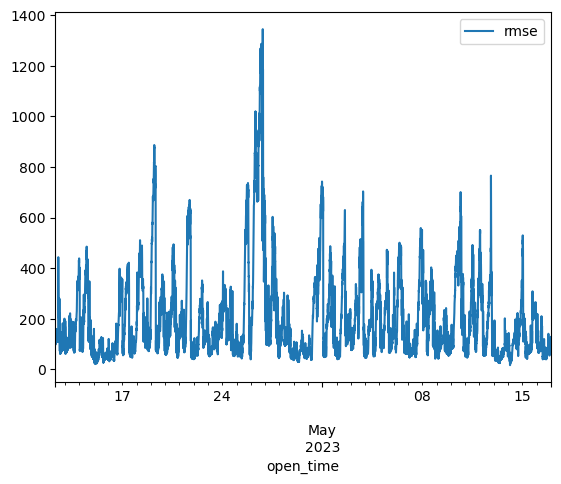

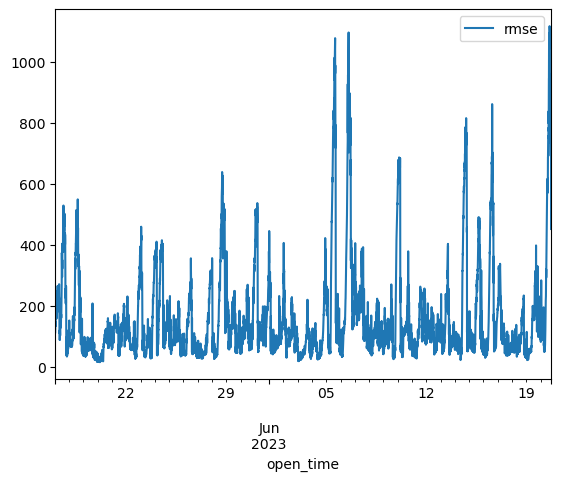

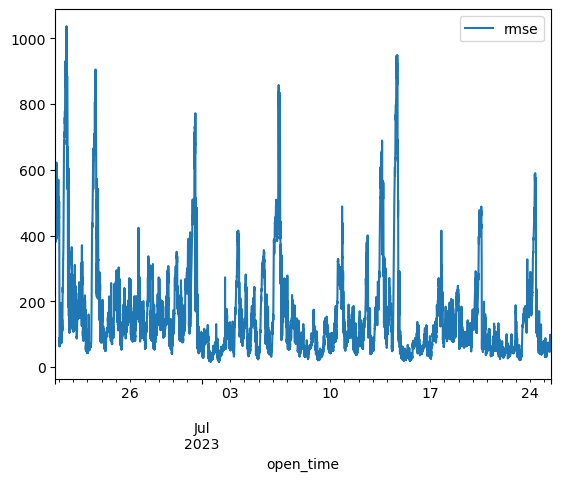

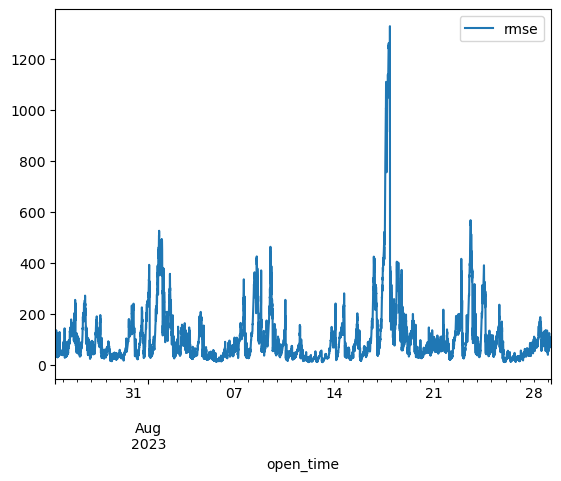

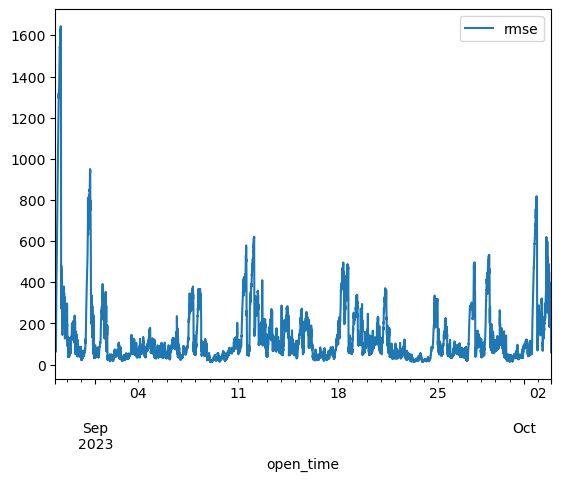

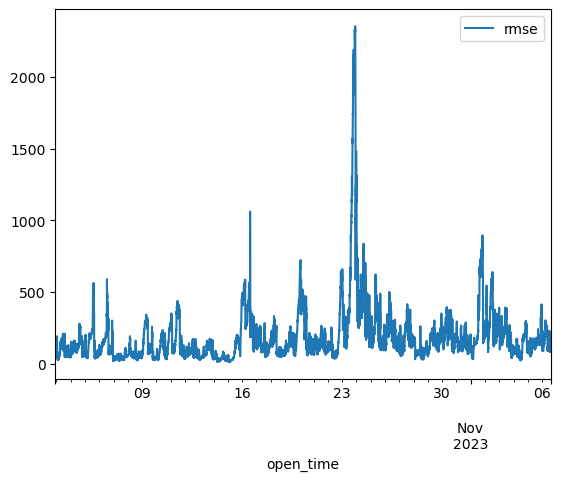

In [18]:
for i in range(6):
    rmse_df.loc[(i*10000):(i+1)*10000].plot(x = 'open_time', y = 'rmse')

In [107]:
rmse_df['rmse'].mean(axis = 0)

163.66746345961624

In [108]:
tt = pd.DataFrame(np.concatenate([y_pred_arr.reshape(-1, 1), y_true.values.reshape(-1, 1)], axis = 1))
tt['diff'] = np.absolute(tt[0] - tt[1])
tt

,0,1,diff
0,36492.222960,36515.43,23.207040
1,36493.775919,36480.01,13.765919
2,36495.328879,36437.34,57.988879
3,36490.092896,36481.14,8.952896
4,36484.856914,36516.01,31.153086
...,...,...,...
95,36467.564832,37381.24,913.675168
96,36467.564832,37390.00,922.435168
97,36467.564832,37427.19,959.625168
98,36467.564832,37448.80,981.235168


In [8]:
train_features = [x for x in df.columns if (x not in cols_to_drop)]

valid_df['token'] = valid_df['token'].astype('category').cat.codes
object_cols = valid_df[train_features].select_dtypes(include=object).columns
valid_df[object_cols] = valid_df[object_cols].astype(float)

nan_features = get_na_features(valid_df, train_features)

feature_cols = pd.DataFrame(train_features)
dtype_df = pd.DataFrame(valid_df[train_features].select_dtypes(exclude=[float]).columns)
train_features = [x for x in train_features if x not in dtype_df.values]

In [9]:
### model parameters
param.layers = [500,350,200]
param.dropout_rate = 0.35

###training parameters
param.bs = 8192
param.lr = 0.002
param.epochs = 30
param.wd = 0.02

In [10]:
groups = pd.factorize(
    train_df['open_time'].dt.day.astype(str) + '_' + train_df['open_time'].dt.month.astype(str) + '_' + train_df[
        'open_time'].dt.year.astype(str))[0]

cv = tscv.PurgedGroupTimeSeriesSplit(
    n_splits=5,
    group_gap=31,
)

In [11]:
from joblib import load, dump

means = load('../output/means_15m.joblib')
std = load('../output/std_15m.joblib')
train_set_features = load('../output/train_features_test_15m.joblib')

In [12]:
def normalize_columns_infer(df, means, stds):
    features = means.index.tolist()
    for feature in features:
        mean = means.loc[feature]
        std = stds.loc[feature]
        df[feature] = (df[feature] - mean) / std
    return df

In [13]:
train_features_test = train_set_features
valid_df = normalize_columns_infer(valid_df, means, std)

In [14]:
nan_features = get_na_features(train_df, train_features)

In [15]:
for k, v in nan_features.items():
  for feat in v:
    train_features.remove(feat)

In [16]:
### adding overall AuC as a metric
### for early stopping I only look at resp and resp_sum because they start overfitting earlier
use_weights = False
metrics =  [tf.keras.metrics.MeanSquaredError(name='loss'),
            tf.keras.metrics.MeanSquaredError(name='mse')]
            # tf.keras.metrics.AUC(name='AUC')]

scores = []
batch_size = 4096

In [17]:
len(train_features_test)

145

In [18]:
fold = 4
min_train, max_train = min(valid_df['open_time']).to_pydatetime(), max(
  valid_df['open_time']).to_pydatetime()

x_train, x_val = valid_df[train_features_test], valid_df[train_features_test]

print(f'Train Date is from {min_train} - {max_train}')

y_train, y_val = valid_df['target_15m'].values, valid_df['target_15m'].values

print(f'Shape of Xtrain is {x_train.shape}, Shape of yTrain is {y_train.shape}')

model = create_model(len(train_features_test), 1, param.layers, param.dropout_rate,
                    optimizer=tfa.optimizers.Lookahead(
                        tfa.optimizers.LAMB(learning_rate=param.lr, weight_decay_rate=param.wd)
                    ),
                    metrics=metrics)
model.load_weights(f'../output/MLP_mse_{fold}_returns15m_11_19.hdf5')

predictions = model.predict(x_val.values)
ypred = pd.DataFrame(predictions, columns = ['ypred'])
cols_to_keep = ['open_time', 'target_15m', 'close', 'open']
x_df = valid_df[cols_to_keep].reset_index(drop = True)
x_df.columns = cols_to_keep
x_df['pred_ret5m'] = ypred['ypred']

Train Date is from 2022-08-16 07:12:00 - 2023-05-17 02:23:00
Shape of Xtrain is (394272, 145), Shape of yTrain is (394272,)
12321/12321 [==============================] - 13s 1ms/step


In [19]:
x_df

,open_time,target_15m,close,open,pred_ret5m
0,2022-08-16 07:12:00,0.000471,-0.354885,-0.355103,0.003362
1,2022-08-16 07:13:00,-0.000104,-0.355334,-0.354884,0.001678
2,2022-08-16 07:14:00,-0.000350,-0.354762,-0.355327,0.002275
3,2022-08-16 07:15:00,0.000100,-0.354666,-0.354761,0.003887
4,2022-08-16 07:16:00,0.000358,-0.354672,-0.354665,0.001617
...,...,...,...,...,...
394267,2023-05-17 02:19:00,-0.001573,-0.178749,-0.178754,0.003006
394268,2023-05-17 02:20:00,-0.002186,-0.178597,-0.178742,0.000415
394269,2023-05-17 02:21:00,-0.002075,-0.178485,-0.178602,-0.000274
394270,2023-05-17 02:22:00,-0.002176,-0.178508,-0.178479,-0.001875


In [20]:
x_df['close'] = (x_df['close']* std.loc['close'] + means.loc['close'])

In [21]:
x_df['close_5m_pred'] = (1 + x_df['pred_ret5m']) * x_df['close']

In [22]:
x_df.plot(x = 'open_time', y = ['close_5m_pred'])

KeyError: "['close_5m'] not in index"

In [ ]:
def calculate_weighted_rmse(predictions: np, actual: np) -> float:
    predictions = np.array(predictions)
    actual = np.array(actual)

    k = 0.001

    weights = np.exp(-k * np.arange(len(predictions)))
    weighted_squared_errors = weights * (predictions - actual) ** 2
    weighted_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))

    return weighted_rmse

In [138]:
weighted_rmse = calculate_weighted_rmse(x_df['close_5m_pred'], x_df['close_5m'])
print(f'weighted rmse: {weighted_rmse}')

weighted rmse: 64.17401026209629


In [74]:
params = {'num_columns': len(train_features_test),
          'num_labels': 1,
          'hidden_units': [96, 96, 896, 448, 448, 256],
          'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882,
                            0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448],
          'ls': 0,
          'lr': 1e-3,
          }

In [75]:
scores = []
batch_size = 4096
df_pred = []

min_train, max_train = min(valid_df['open_time']).to_pydatetime(), max(valid_df['open_time']).to_pydatetime()
min_valid, max_valid = min(valid_df['open_time']).to_pydatetime(), max(
              valid_df['open_time']).to_pydatetime()

x_train, x_val = valid_df[train_features_test], valid_df[train_features_test]
print(f'Valid Date is from {min_valid} - {max_valid}')

y_train, y_val = valid_df['target_5m'], valid_df['target_5m']
print(f'Shape of Xtrain is {x_train.shape}, Shape of yTrain is {y_train.shape}')

model = create_ae_mlp(**params)
model.load_weights(f'../output/AEMLP_MSE_0_{batch_size}.hdf5')

predictions = model.predict(x_val.values)
preds = predictions[-1]
ypred = pd.DataFrame(preds, columns = ['ypred'])
cols_to_keep = ['open_time', 'target_5m', 'close', 'open', 'close_5m']
x_df = valid_df[cols_to_keep].reset_index(drop = True)
x_df['pred_ret5m'] = ypred['ypred']

Valid Date is from 2022-08-16 07:12:00 - 2023-05-17 02:23:00
Shape of Xtrain is (394272, 151), Shape of yTrain is (394272,)
12321/12321 [==============================] - 27s 2ms/step


KeyError: "['label'] not in index"

In [79]:
cols_to_keep = ['open_time', 'target_5m', 'close', 'open', 'close_5m']
x_df = valid_df[cols_to_keep].reset_index(drop = True)
x_df['pred_ret5m'] = ypred['ypred']
x_df['close_5m_pred'] = (1 + x_df['pred_ret5m']) * x_df['close']

In [80]:
def calculate_weighted_rmse(predictions: np, actual: np) -> float:
    predictions = np.array(predictions)
    actual = np.array(actual)

    k = ValiConfig.RMSE_WEIGHT

    weights = np.exp(-k * np.arange(len(predictions)))
    weighted_squared_errors = weights * (predictions - actual) ** 2
    weighted_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))

    return weighted_rmse

In [86]:
x_df = x_df.drop(['close', 'open'], axis = 1)
df_to_keep = valid_df[['open_time', 'close']]
new_df = x_df.merge(df_to_keep, left_on = ['open_time'], right_on = ['open_time'], how = 'inner')
new_df['close_5m_pred'] = (1 + new_df['pred_ret5m']) * new_df['close']

In [88]:
new_df['close_5m_pred'] = (1 + new_df['pred_ret5m']) * new_df['close']

In [89]:
valid_wrmse = calculate_weighted_rmse(x_df['close_5m_pred'], x_df['close_5m'])
print(valid_wrmse)

23822.790749928434


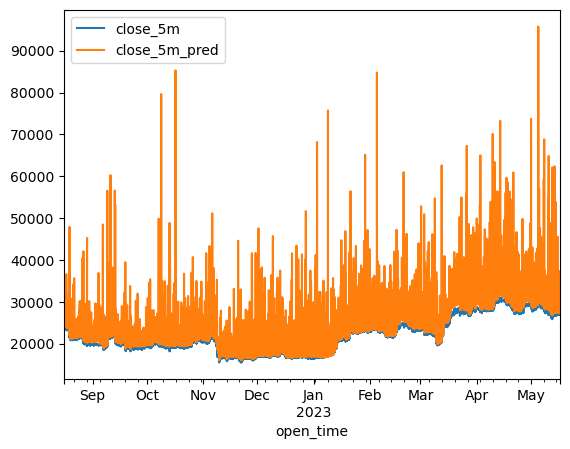

In [94]:
ax = new_df.plot(x = 'open_time', y = ['close_5m', 'close_5m_pred'])

In [92]:
(23990/23989.6)-1

1.6673892019980485e-05

In [91]:
new_df

,open_time,target_5m,close_5m,pred_ret5m,close_5m_pred,close
0,2022-08-16 07:12:00,-0.000017,23990.0,0.034901,24826.853000,23989.6
1,2022-08-16 07:13:00,-0.000392,23991.0,0.036496,24856.844945,23981.6
2,2022-08-16 07:14:00,-0.000217,23997.0,0.035883,24852.690836,23991.8
3,2022-08-16 07:15:00,0.000042,23992.5,0.041578,24991.091608,23993.5
4,2022-08-16 07:16:00,0.000225,23988.0,0.029742,24707.003182,23993.4
...,...,...,...,...,...,...
394267,2023-05-17 02:19:00,0.000243,27123.4,0.034690,28071.143544,27130.0
394268,2023-05-17 02:20:00,0.000454,27120.4,0.034970,28081.538211,27132.7
394269,2023-05-17 02:21:00,0.000704,27115.6,0.030422,27960.197561,27134.7
394270,2023-05-17 02:22:00,0.000513,27120.4,0.029899,27945.591701,27134.3
